In [1]:
import numpy as np
# Constants
IMAGE_WIDTH = 28
KERNEL_SIZE = 9
POOL_KERNEL_SIZE = 5
CLASSES = 4
EPOCHS = 10
BATCH_SIZE = 256
PERTURB = False

## Settings
DEBUG = False
FILENAME_PREFIX = "dn-mnist"
CHOOSE_NEW_TRAINING_DATA = True

TARGETS = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [2]:
# Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random

from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed, nn
from torch.nn import Linear, CrossEntropyLoss, MSELoss, Softmax, Parameter
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    NLLLoss,
    AvgPool2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    BatchNorm2d,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform


In [3]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = BATCH_SIZE
n_samples = CLASSES * 10000  # We will concentrate on the first 6000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA):
  # Use pre-defined torchvision function to load MNIST train data
  X_train = datasets.MNIST(
      root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
  )

  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(X_train.targets < CLASSES)[0][:n_samples]
  X_train.data = X_train.data[idx]
  X_train.targets = X_train.targets[idx]

  print("X_train.data", X_train.data.shape)
  # Define torch dataloader with filtered data
  train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
  torch.save(train_loader, f'checkpoints/{FILENAME_PREFIX}-training-{CLASSES}.pt')
else:
  train_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-training-{CLASSES}.pt')

X_train.data torch.Size([24754, 28, 28])


images shape torch.Size([256, 1, 28, 28])


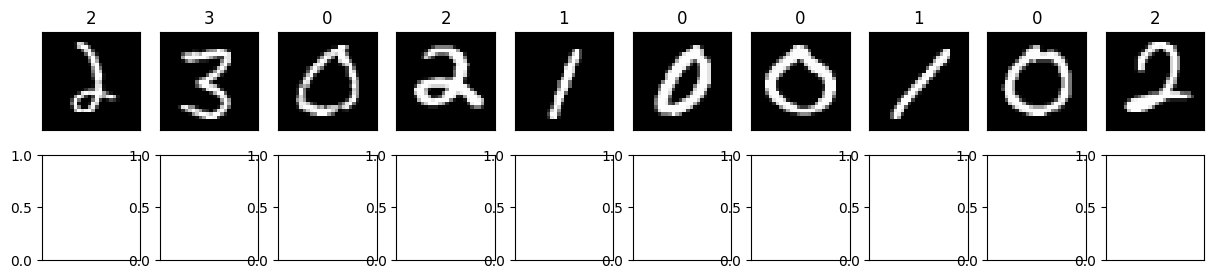

In [4]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))

    n_samples_show -= 1

In [5]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
manual_seed(5)

n_samples = CLASSES * 1000  # We will concentrate on 1000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA):
  # Use pre-defined torchvision function to load MNIST test data
  X_test = datasets.MNIST(
      root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
  )

  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(X_test.targets < CLASSES)[0][:n_samples]
  X_test.data = X_test.data[idx]
  X_test.targets = X_test.targets[idx]

  # Define torch dataloader with filtered data
  test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
  torch.save(test_loader, f'checkpoints/{FILENAME_PREFIX}-testing-{CLASSES}.pt')
else:
  test_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-testing-{CLASSES}.pt')

In [6]:
# Define torch NN module
convImageSize = 7
outputChannels = 8
poolOutputChannels = convImageSize - POOL_KERNEL_SIZE + 1
M = 2
abs_v_l1_weight = 0

class Net(Module):
    def __init__(self):
      super().__init__()
      self.conv1 = Conv2d(1, outputChannels, kernel_size=KERNEL_SIZE, stride= 3, padding=0) # output: BATCHSIZE x outputChannels x convImageSize x convImageSize
      self.relu1 = ReLU() # output: 256 x 28 x 20 x 20
      self.dn_exponent = Parameter(torch.abs(nn.init.trunc_normal_(torch.empty(1, 1, 1, convImageSize), mean=1.0, std=0.01)))
      self.ap1 = AvgPool2d(kernel_size=POOL_KERNEL_SIZE, stride=1) 

      # Define u_unnormalized as a learnable parameter
      u_shape = (outputChannels, outputChannels, 1, poolOutputChannels, M)
      self.u_unnormalized = nn.Parameter(
            torch.randn(u_shape) * 1e-3,
            requires_grad=True
      )

      # Define v as a learnable parameter
      self.v = nn.Parameter(
          torch.randn(1, 1, poolOutputChannels, poolOutputChannels, M) * 1e-3,
          requires_grad=True
      )

      # Calculate absolute values of u and v
      # self.conv2 = Conv2d(IMAGE_WIDTH, 2*IMAGE_WIDTH, kernel_size=3)
      # self.bn2 = BatchNorm2d(2*IMAGE_WIDTH)
      # self.relu2 = ReLU()
      # self.mp2 = MaxPool2d(2, 2) # output: 128 x 8 x 8

      self.fc1 = Linear(outputChannels, CLASSES)
      # self.drop = Dropout2d(0.25)
      # self.fc2 = Linear(600, 120)
      # self.fc3 = Linear(120, CLASSES)

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      # print("after conv 1, x shape", x.shape)
      x = torch.pow(x, self.dn_exponent)
      # print("after dnexp, x shape", x.shape)
      x = self.ap1(x)
      # print("after avgpool, x shape", x.shape)

      # Normalize u using Frobenius norm
      norm_u = torch.norm(self.u_unnormalized.view(-1, poolOutputChannels, 2), p='fro', dim=0, keepdim=True)
      self.u = self.u_unnormalized / norm_u

      self.abs_u = torch.abs(self.u)
      self.abs_v = torch.abs(self.v)
      # print("absv", self.abs_v.shape, self.abs_u.shape)
      abs_v_l1_penalty = abs_v_l1_weight * torch.sum(self.abs_v)

      # Compute p_m and p
      p_m = self.abs_u * self.abs_v
      # print("pm shape", p_m.shape)
      p = torch.sum(p_m, dim=-1)  # Sum over normalization pools (m dimension)
      # print("p shape", p.shape)
      x = F.conv2d(x, p, stride=1, padding=0, dilation=1)
      # print("after conv2d 2, x shape", x.shape)
      x = x.view(x.size(0), -1)
      # print("after view", x.shape)
      x = self.fc1(x)
      # print("after fc1", x.shape)
      # x = self.bn2(x)
      # x = self.relu2(x)
      # x = self.mp2(x)
      # x = x.view(x.size(0), -1)
      # x = self.fc1(x)
      # x = self.drop(x)
      # x = self.fc2(x)
      # x = self.fc3(x)

      return x, abs_v_l1_penalty


model = Net()

In [7]:
# Define model, optimizer, and loss function
start_time = datetime.now()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = EPOCHS  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode
# m = Softmax(dim=3)

torch.autograd.set_detect_anomaly(True)

print("Training Set size:", len(train_loader.dataset), "Epochs", EPOCHS, "Batch Size:", BATCH_SIZE, "Number of batches:", (len(train_loader.dataset)//BATCH_SIZE)+1)
total_loss = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        if(DEBUG):
          print("epoch", epoch, "batch", batch_idx)
        output, abs_v_l1_penalty = model(data)  # Forward pass
        loss = loss_func(output, target) + abs_v_l1_penalty  # Calculate loss
        print(epoch, batch_idx, "Loss", loss.item())
        loss.backward(retain_graph=True)  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-c{CLASSES}-{epoch}.pt')
end_time = datetime.now()
elapsed = end_time - start_time
print("Training Time: {:.0f} seconds]".format(elapsed.total_seconds()))

Training Set size: 24754 Epochs 10 Batch Size: 256 Number of batches: 97
0 0 Loss 1.3880754709243774
0 1 Loss 1.3995981216430664
0 2 Loss 1.3744817972183228
0 3 Loss 1.409702181816101
0 4 Loss 1.394290566444397
0 5 Loss 1.4085091352462769
0 6 Loss 1.3859293460845947
0 7 Loss 1.3942009210586548
0 8 Loss 1.3946492671966553
0 9 Loss 1.4007591009140015
0 10 Loss 1.397518277168274
0 11 Loss 1.3938254117965698
0 12 Loss 1.3886442184448242
0 13 Loss 1.3827292919158936
0 14 Loss 1.3861736059188843
0 15 Loss 1.3895670175552368
0 16 Loss 1.385256052017212
0 17 Loss 1.3761062622070312
0 18 Loss 1.3775634765625
0 19 Loss 1.3866766691207886
0 20 Loss 1.3902587890625
0 21 Loss 1.3789929151535034
0 22 Loss 1.3793199062347412
0 23 Loss 1.3824210166931152
0 24 Loss 1.382419228553772
0 25 Loss 1.3805840015411377
0 26 Loss 1.3799349069595337
0 27 Loss 1.3829385042190552
0 28 Loss 1.3741819858551025
0 29 Loss 1.3722467422485352
0 30 Loss 1.3752690553665161
0 31 Loss 1.3774510622024536
0 32 Loss 1.37333822

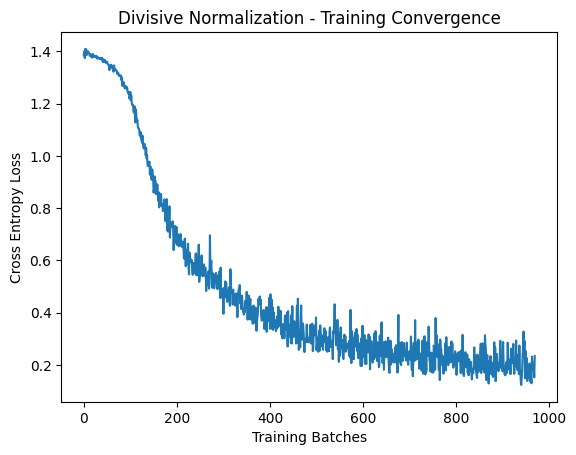

In [8]:
# Plot loss convergence
plt.plot(total_loss)
plt.title("Divisive Normalization - Training Convergence")
plt.xlabel("Training Batches")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [9]:
def plotKernel(ax, locations, kernels, tunings, title):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=[]
  for iy, ix in np.ndindex(locations.shape):
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y)
    X.append(x)
    ks = kernels[iy, ix].item()
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    tuningValue.append(tunings[iy, ix].item())
    ax.add_patch(Rectangle((x.item(), y.item()), size, size, facecolor= 'none', edgecolor=next(cycol), alpha=0.75))
  ax.scatter(tuningX, tuningY,c=tuningValue, s=kernelSize, cmap='Greys', alpha=0.75)
    # print(x.item(), y.item(), kernels[iy, ix].item())



In [10]:
n_samples_show = 6
count = 0

with no_grad():

  
  print("Testing Set size:", len(test_loader.dataset), "Batch Size:", BATCH_SIZE, "Number of batches:", (len(test_loader.dataset)//BATCH_SIZE)+1)

  for epoch in range(EPOCHS):
    model = Net()
    model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-c{CLASSES}-{epoch}.pt'))
    model.eval()  # set model to evaluation mode
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(test_loader):
      perturbations = []
      perturbedData = data
      if(PERTURB):
        perturbedData = torch.zeros_like(perturbedData)
        for bi in range(0, data.shape[0]):
          originalImage = data[bi,0]
          match random.randint(0, 3):
              case 0:
                perturbedImage = skew(originalImage.numpy())
                perturbations.append("skew")
              case 1:
                angle = 3*np.random.random()/5
                perturbedImage = rotate(originalImage.numpy(), angle)
                perturbations.append(f"rotate {np.round(angle*180/np.pi)}°")
              case 2:
                perturbedImage = noise(originalImage.numpy())
                perturbations.append("noise")
              case _:
                perturbedImage = elastic_transform(originalImage.numpy())
                perturbations.append("elastic")
          perturbedData[bi] = torch.tensor(perturbedImage).unsqueeze(0)

      output, loss = model(perturbedData)
      # print("prediction output", output)
      print(batch_idx+1, end=" ")
      # if len(output.shape) == 1:
      #     output = output.reshape(1, *output.shape)

      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

      loss = loss_func(output, target)
      total_loss.append(loss.item())
      count += 1

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tClasses: {}, \n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), 
            CLASSES, correct / len(test_loader) / batch_size * 100
        )
    )


Testing Set size: 4000 Batch Size: 256 Number of batches: 16
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 1.2326
	Classes: 4, 
	Accuracy: 46.5%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.7065
	Classes: 4, 
	Accuracy: 68.5%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.4950
	Classes: 4, 
	Accuracy: 75.7%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.3454
	Classes: 4, 
	Accuracy: 87.4%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.2701
	Classes: 4, 
	Accuracy: 90.1%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.2176
	Classes: 4, 
	Accuracy: 91.7%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.1870
	Classes: 4, 
	Accuracy: 92.7%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Loss: 0.1719
	Classes: 4, 
	Accuracy: 93.0%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test 

In [11]:
import qiskit.tools.jupyter

%qiskit_version_table